# Experimenting with Compression Matrix Learning in Torch

In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DATA = './data'
batch_size = 32
dataset = "mnist"

if dataset == "fmnist":
    transforms = transforms.Compose([
        ToTensor(),
    ])
    trainset = FashionMNIST(DATA, train=True, transform=ToTensor(), target_transform=None, download=True)
    testset = FashionMNIST(DATA, train=False, transform=ToTensor(), target_transform=None, download=True)
else:
    trainset = MNIST(DATA, train=True, transform=ToTensor(), target_transform=None, download=True)
    testset = MNIST(DATA, train=False, transform=ToTensor(), target_transform=None, download=True)

def remap_data(X, new_max, new_min, max=None, min=None):
    if min is None:
        min = torch.min(X)
    
    if max is None:
        max = torch.max(X)
    
    X = (X - min) * (new_max - new_min) / (max - min) + new_min
    return X

def center_X(X, mu=None):
    if mu is None:
        mu = torch.mean(X.double(), dim=0)
        mu = torch.round(mu)
        mu = torch.unsqueeze(mu, 0).to(torch.float32)
    diff = X - mu 
    new_max = 255
    new_min = 0
    X_centered = remap_data(diff, new_max, new_min).to(torch.uint8)
    mu = remap_data(mu, new_max, new_min, torch.max(diff), torch.min(diff)).to(torch.uint8)
    return X_centered, mu

trainset.data, mu = center_X(trainset.data)
print(trainset.data[0])
trainset.data = torch.clamp(trainset.data, min=0, max=255)
#testset.data = remap_dataset(testset.data)
testset.data, _ = center_X(testset.data, mu)
testset.data = torch.clamp(testset.data, min=0, max=255)

train = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test = DataLoader(testset, batch_size=batch_size, shuffle=True)

tensor([[ 90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,
          90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90],
        [ 90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,
          90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90,  90],
        [ 90,  90,  90,  90,  90,  90,  90,  90,  90,  89,  89,  89,  89,  88,
          88,  87,  87,  88,  88,  89,  89,  89,  90,  90,  90,  90,  90,  90],
        [ 90,  90,  90,  90,  90,  90,  90,  89,  89,  89,  87,  87,  85,  83,
          82,  81,  81,  82,  83,  85,  87,  89,  89,  90,  90,  90,  90,  90],
        [ 90,  90,  90,  90,  90,  90,  89,  89,  87,  85,  81,  78,  72,  67,
          63,  61,  61,  65,  70,  75,  80,  84,  87,  89,  89,  90,  90,  90],
        [ 90,  90,  90,  90,  90,  89,  87,  85,  81,  76,  69,  61,  54,  54,
          47,  43, 114, 126, 160,  74, 175, 240, 242, 167,  88,  89,  90,  90],
        [ 90,  90,  90,  90,  89,  88,  85,  8

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


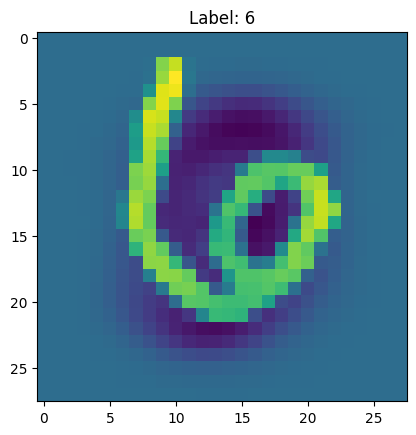

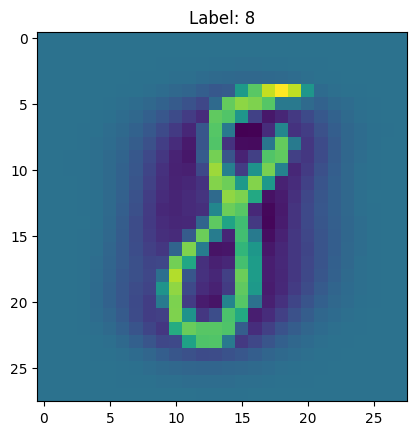

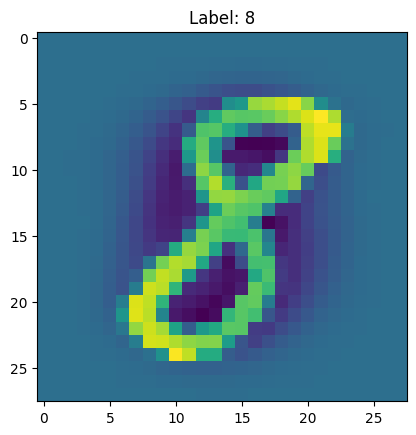

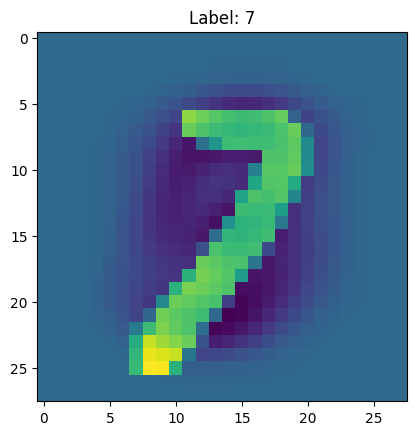

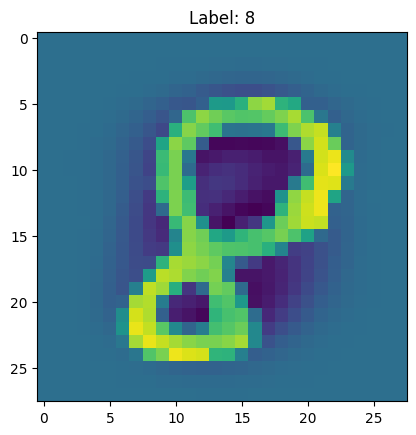

In [2]:
features, labels = next(iter(train))

# Plot a few members of the batch
for i in range(5):
    plt.figure()
    plt.title(f"Label: {labels[i]}")
    print(features[i].size())
    plt.imshow(features[i].squeeze())

## Implementing the Compression Matrix with Torch

$$\mathbf{z}=B^T\mathbf{x},\quad\mathbf{\tilde{x}}=B\mathbf{z}$$

where $B$ is the compression matrix, $\mathbf{z}$ is the compressed representation, and $\mathbf{\tilde{x}}$ is the reconstructed representation.

(Note to self: Torch represents the transform performed by a linear layer as $\mathbf{y}=\mathbf{x}A^T+\mathbf{b}.$)

In [3]:
class CompressionMatrix(torch.nn.Module):
    def __init__(self, input_dim, compressed_dim):
        super().__init__()
        
        # compressed_dim and input_dim passed in this order so that the weight attribute
        # has the same shape as the compression (B) matrix as described above.
        self.compression_matrix = torch.nn.Linear(compressed_dim, input_dim, bias=False)

    def forward(self, x):
        z = self.compression_matrix.weight.t()@x
        return self.compression_matrix(z.t())

    def encode(self, x):
        return self.compression_matrix.weight.t()@x

    def decode(self, z):
        return self.compression_matrix(z.t())

def avg_squared_error_loss(x, x_tilde):
    ''' Simple loss function '''
    loss = 0
    for i in range(batch_size):
        loss += (x[i] - x_tilde[i]).t()@(x[i] - x_tilde[i])
        
    return loss / batch_size

def compression_loss(x, x_tilde):
    ''' Compression loss function '''
    pass

## Training the Model

 epoch 1 batch 100 loss: 6.3390995807647705
 epoch 1 batch 200 loss: 2.271135799407959
 epoch 1 batch 300 loss: 2.145656583786011
 epoch 1 batch 400 loss: 2.0407098598480227
 epoch 1 batch 500 loss: 1.9653758373260497
 epoch 1 batch 600 loss: 1.940917776107788
 epoch 1 batch 700 loss: 1.9149512844085694
 epoch 1 batch 800 loss: 1.8861753482818604
 epoch 1 batch 900 loss: 1.8875928478240966
 epoch 1 batch 1000 loss: 1.896555561065674
 epoch 1 batch 1100 loss: 1.886739049911499
 epoch 1 batch 1200 loss: 1.884374418258667
 epoch 1 batch 1300 loss: 1.8711762084960937
 epoch 1 batch 1400 loss: 1.884144889831543
 epoch 1 batch 1500 loss: 1.8639053611755372
 epoch 1 batch 1600 loss: 1.8769550132751465
 epoch 1 batch 1700 loss: 1.864626669883728
 epoch 1 batch 1800 loss: 1.869138512611389
 epoch 2 batch 100 loss: 3.291291480064392
 epoch 2 batch 200 loss: 1.8769905223846435
 epoch 2 batch 300 loss: 1.8627382488250732
 epoch 2 batch 400 loss: 1.8619572944641114
 epoch 2 batch 500 loss: 1.861882

/var/folders/bj/ytgvxv_x099_76d27h5zg2mw0000gn/T/ipykernel_89666/1775423844.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


 epoch 7 batch 100 loss: 1.5224692816734313
 epoch 7 batch 200 loss: 0.8688276891708374
 epoch 7 batch 300 loss: 0.855097592830658
 epoch 7 batch 400 loss: 0.8573096179962159
 epoch 7 batch 500 loss: 0.8377767791748046
 epoch 7 batch 600 loss: 0.8544160580635071
 epoch 7 batch 700 loss: 0.8260065298080445
 epoch 7 batch 800 loss: 0.8342581872940064
 epoch 7 batch 900 loss: 0.8425286688804626
 epoch 7 batch 1000 loss: 0.838390498161316
 epoch 7 batch 1100 loss: 0.8434783930778503
 epoch 7 batch 1200 loss: 0.8204255571365356
 epoch 7 batch 1300 loss: 0.8295223860740661
 epoch 7 batch 1400 loss: 0.8169308071136474
 epoch 7 batch 1500 loss: 0.8240685095787048
 epoch 7 batch 1600 loss: 0.8192710304260253
 epoch 7 batch 1700 loss: 0.8104669904708862
 epoch 7 batch 1800 loss: 0.8196149244308472
 epoch 8 batch 100 loss: 1.4071922583580017
 epoch 8 batch 200 loss: 0.793984778881073
 epoch 8 batch 300 loss: 0.7918861393928528
 epoch 8 batch 400 loss: 0.7934722762107849
 epoch 8 batch 500 loss: 0

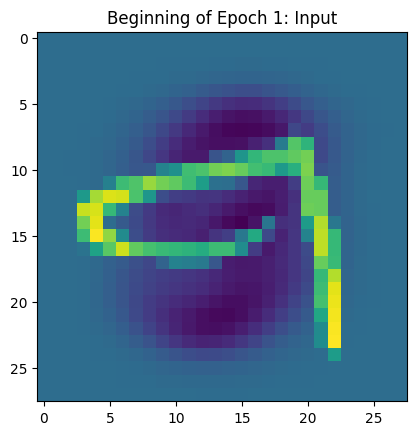

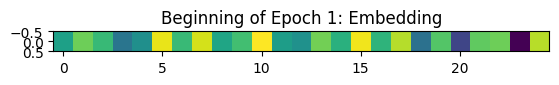

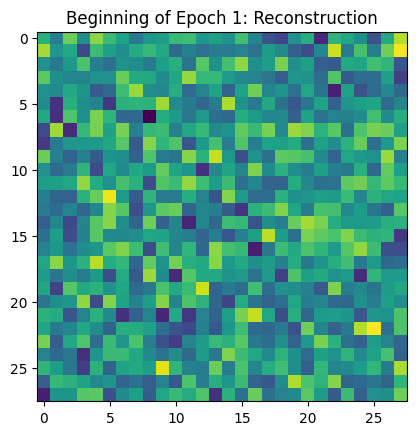

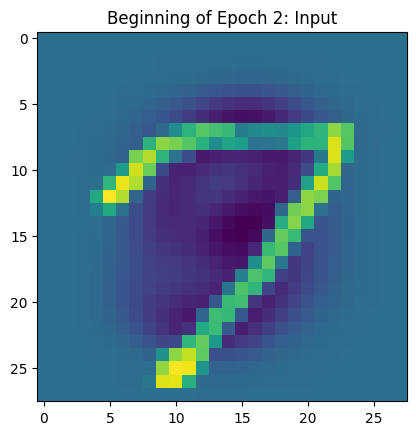

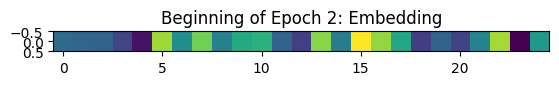

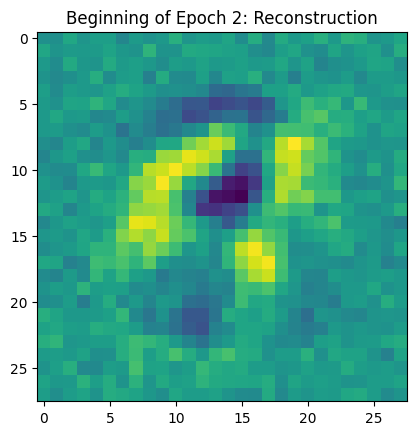

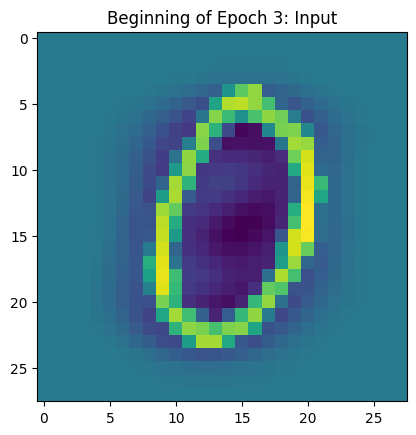

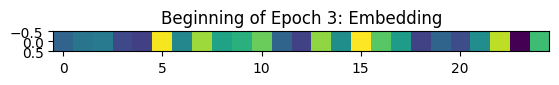

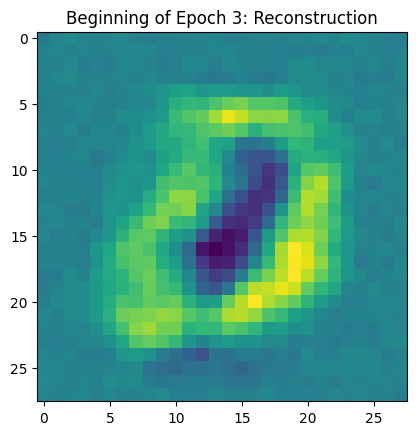

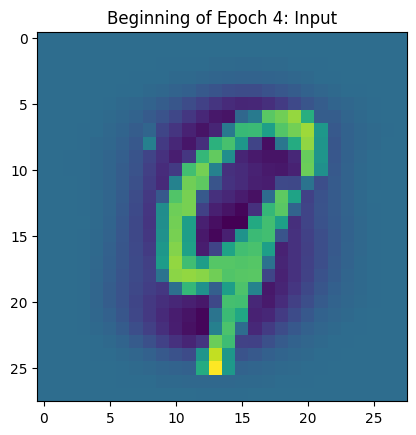

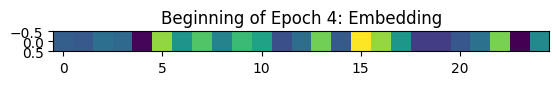

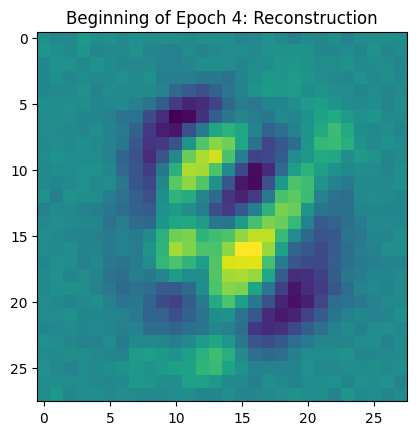

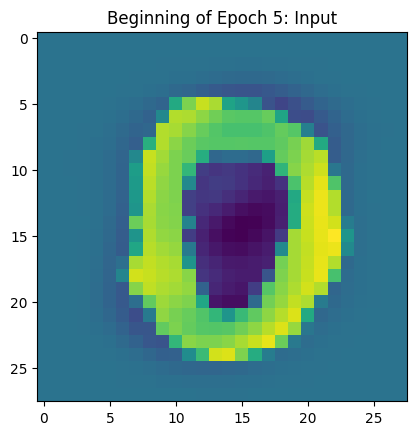

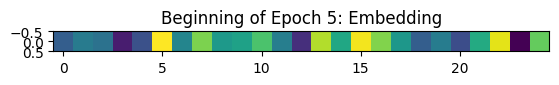

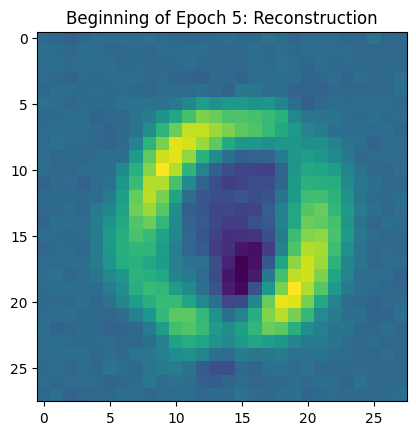

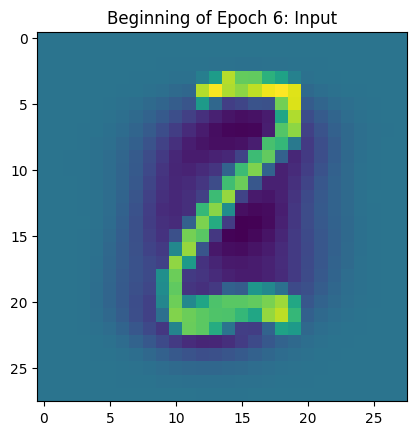

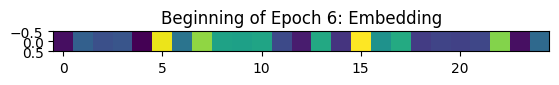

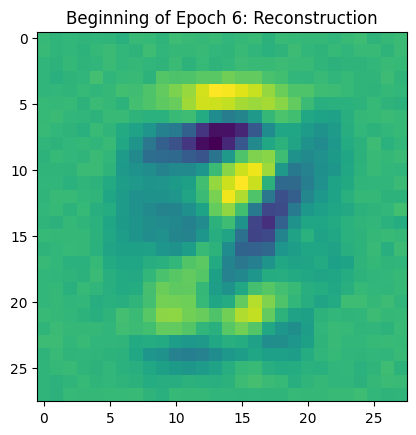

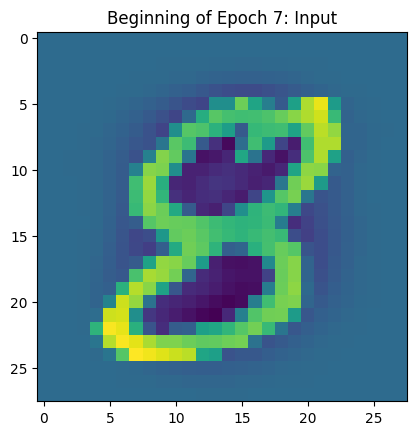

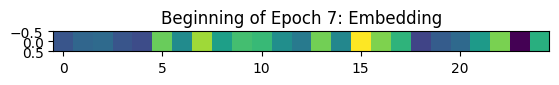

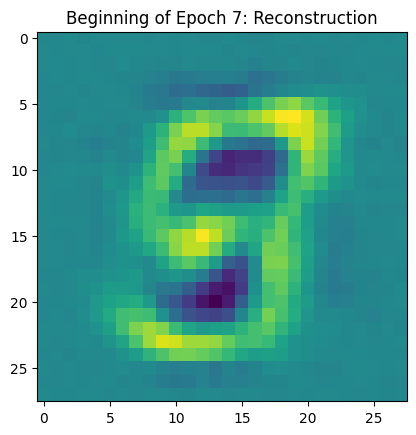

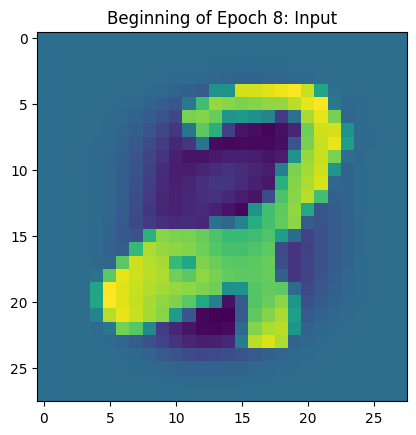

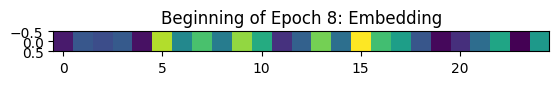

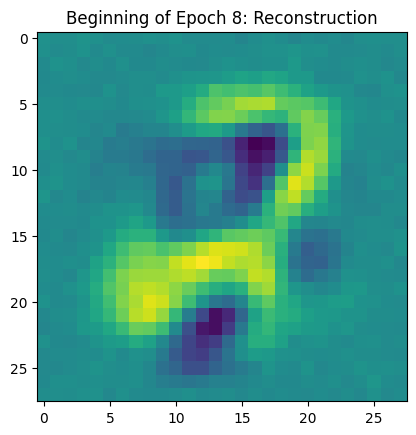

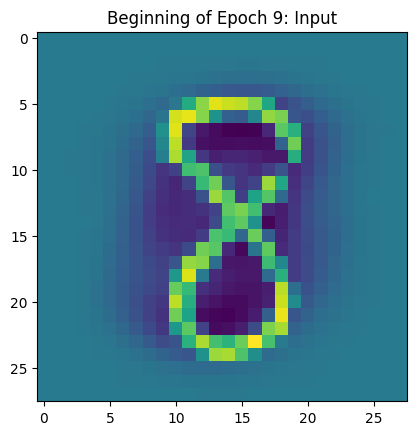

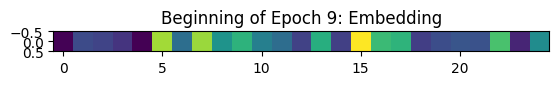

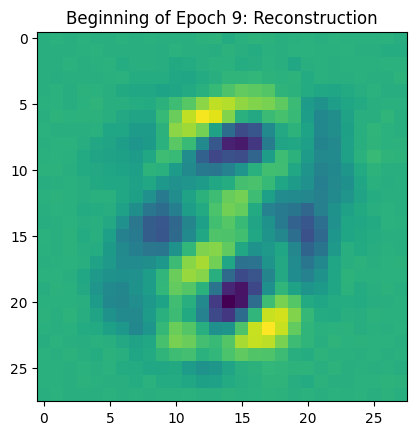

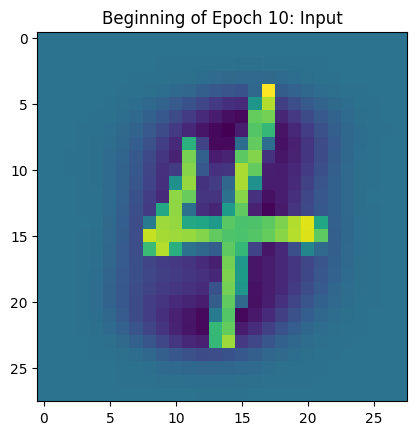

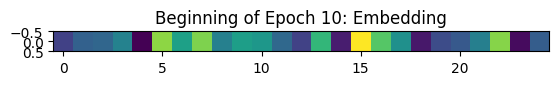

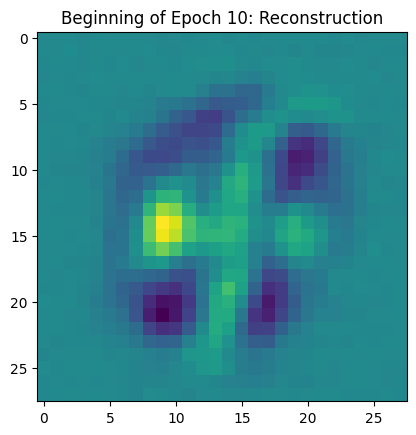

In [4]:
compressed_size = 25

# For MNIST and FMNIST, input dim is 28x28 = 784
if dataset in {"mnist", "fmnist"}:
    input_dim = 784

num_epochs = 10

compression_matrix = CompressionMatrix(input_dim, compressed_size)
optimizer = torch.optim.SGD(compression_matrix.parameters(), lr=0.001, momentum=0.9)
running_loss = 0.
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train):
        # Transpose because features need to be columns
        flat_features = torch.flatten(features, start_dim=1).t()
    
        # Zero the gradients
        optimizer.zero_grad()
    
        if i == 0:
            plt.figure()
            plt.title(f"Beginning of Epoch {epoch + 1}: Input")
                
            plt.imshow(flat_features[:,1].reshape((28,28)))
    
        # Forward pass
        reconstructed = compression_matrix(flat_features)
    
        if i == 0:
            plt.figure()
            plt.title(f"Beginning of Epoch {epoch + 1}: Embedding")
            plt.imshow(compression_matrix.encode(flat_features[:,1].t()).detach().reshape((1, compressed_size)))
            plt.figure()
            plt.title(f"Beginning of Epoch {epoch + 1}: Reconstruction")
            plt.imshow(reconstructed[1].detach().reshape((28,28)))
    
        # Compute the loss and run the backward pass
        loss = avg_squared_error_loss(flat_features.t(), reconstructed)
        loss.backward()
    
        # Adjust the weights in response to the gradients
        optimizer.step()
    
        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 1000 # loss per batch
            print(' epoch {} batch {} loss: {}'.format(epoch + 1, i + 1, last_loss))
            running_loss = 0.

## Visualizing contributions from Columns of $B$

/var/folders/bj/ytgvxv_x099_76d27h5zg2mw0000gn/T/ipykernel_89666/2722962374.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


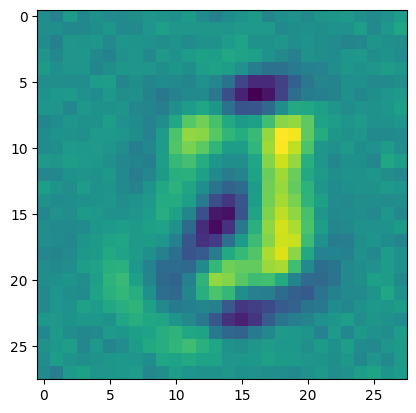

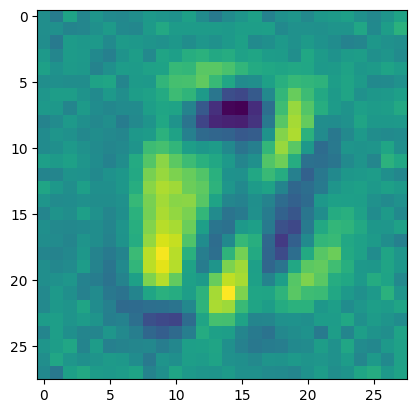

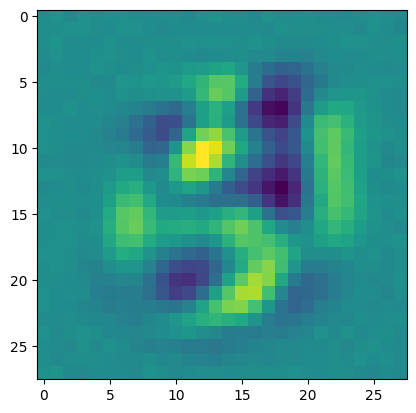

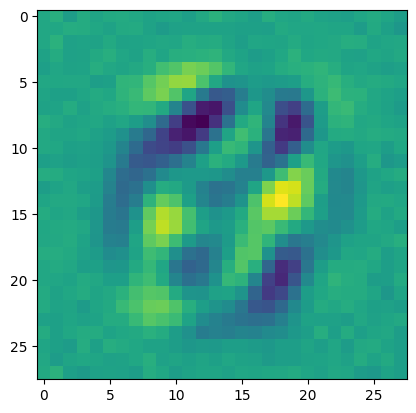

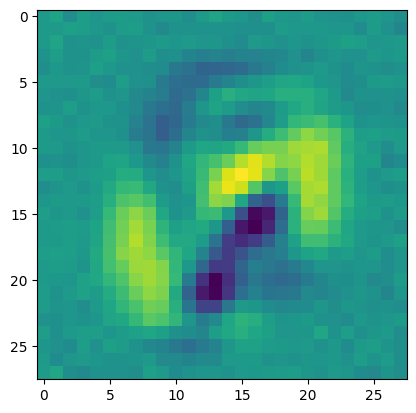

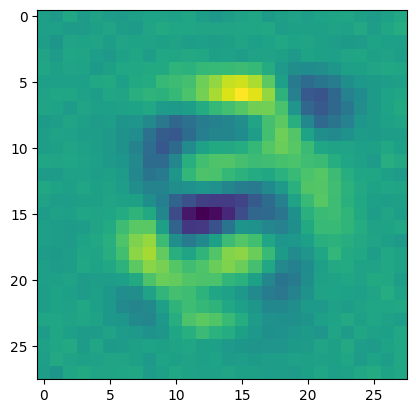

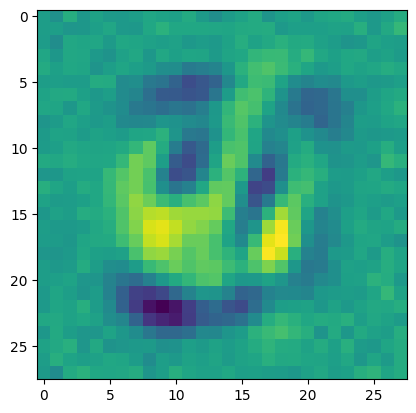

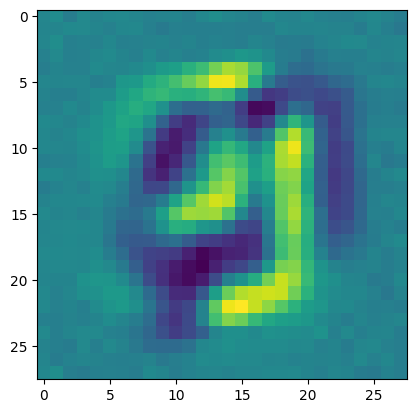

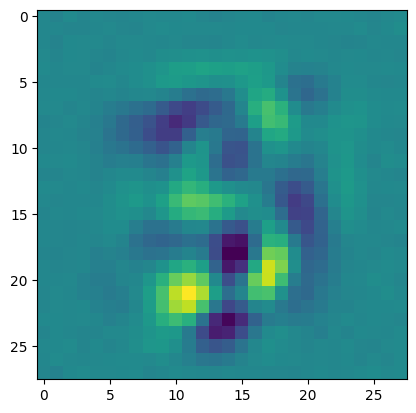

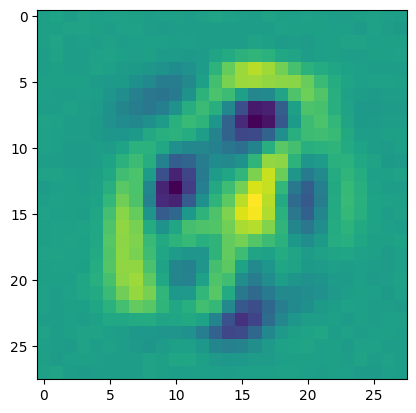

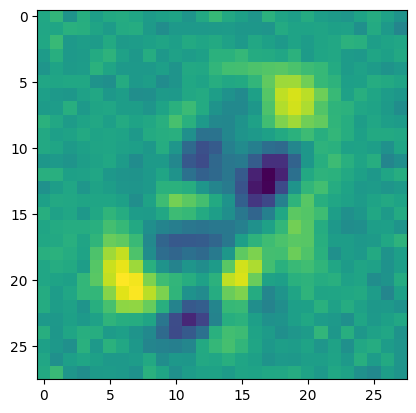

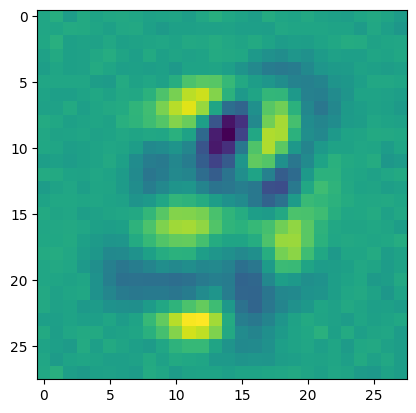

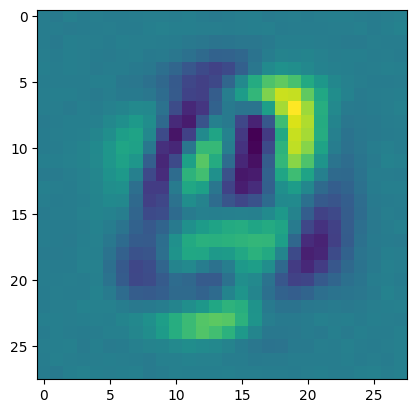

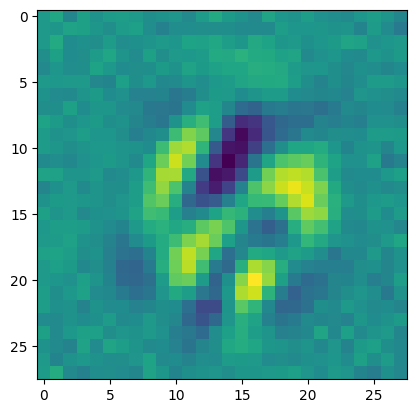

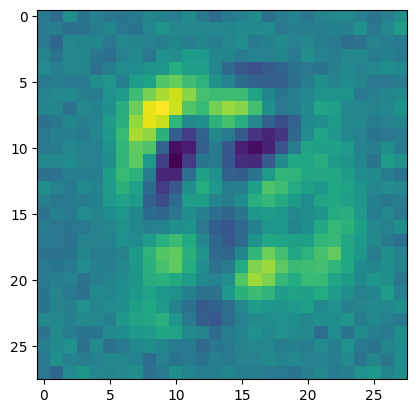

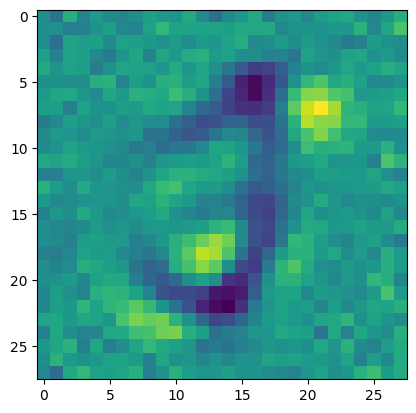

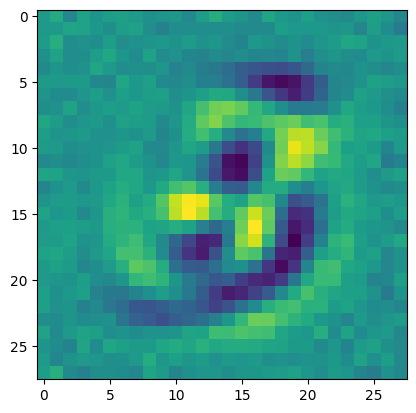

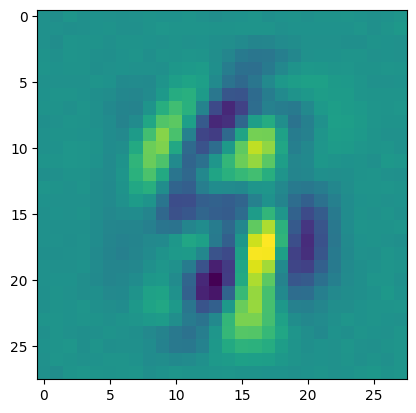

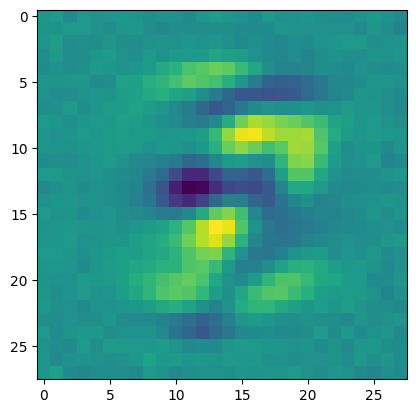

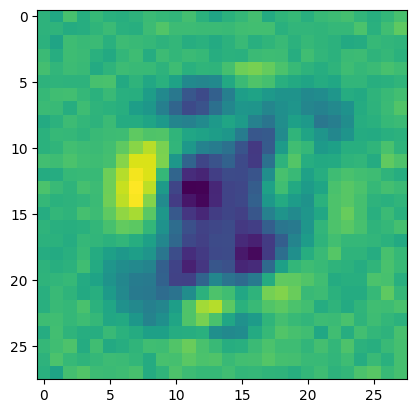

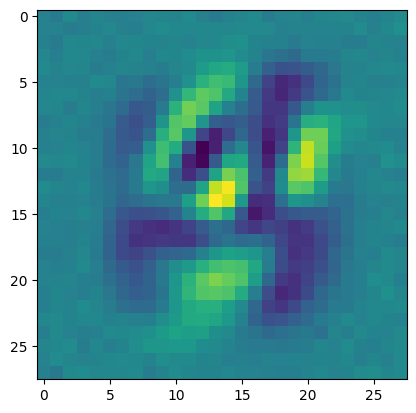

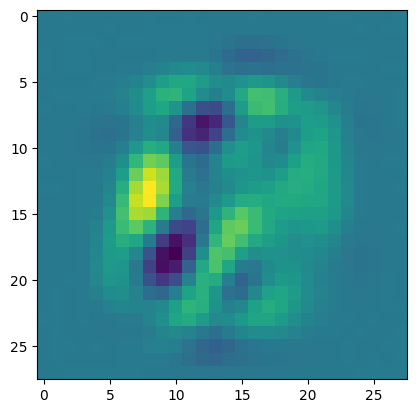

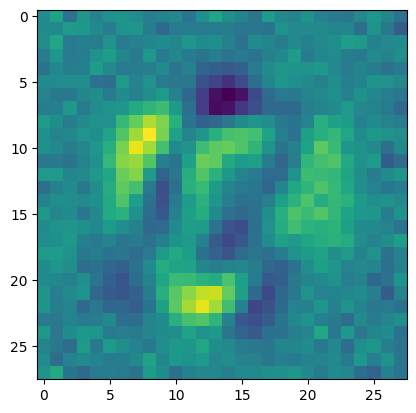

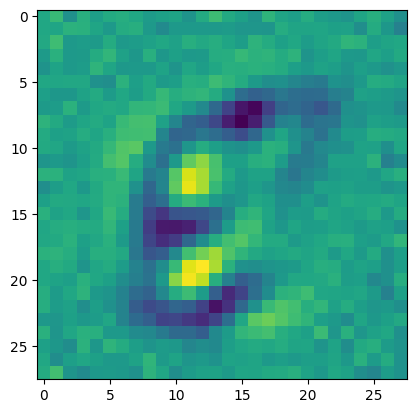

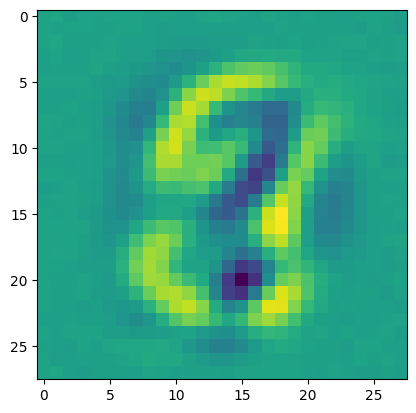

In [5]:
for i in range(25):
    plt.figure()
    plt.imshow(compression_matrix.compression_matrix.weight[:,i].detach().reshape((28, 28)))